# Real Case Neural Network

In this notebook we will present a full example of training a (bigger) neural network, with a not artificial dataset (we will use MNIST).

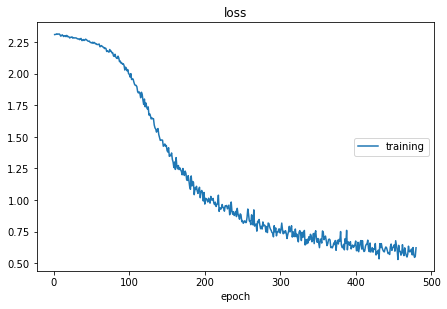


Test set: Average loss: 0.2729, Accuracy: 9251/10000 (93%)



In [5]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from livelossplot import PlotLosses

TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 1000
EPOCHS = 10
LOG_INTERVAL = 100   # how many batches to wait before logging training status

LR = 0.01
MOMENTUM = 0.5

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def train(model, device, train_loader, optimizer, epoch, liveloss):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        liveloss.update({'loss': loss.item()})
        liveloss.draw()
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def main():


    seed = 667
    torch.manual_seed(seed)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # Download datasets
    train_MNIST = datasets.MNIST('../data', train=True, download=True,
                                 transform=transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.1307,), (0.3081,))]))
    test_MNIST =  datasets.MNIST('../data', train=False,
                                 transform=transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.1307,), (0.3081,))]))
    # Fork into the DataLoader object
    train_loader = torch.utils.data.DataLoader(dataset=train_MNIST,batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_MNIST, batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

    # Define the model (remember to assign it to cuda)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    
    liveloss_train = PlotLosses()
    for epoch in range(1, EPOCHS + 1):
        train(model, device, train_loader, optimizer, epoch, liveloss_train)
        test(model, device, test_loader)


if __name__ == '__main__':
    main()